# Classification II: Discriminative models

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/git/https%3A%2F%2Fgitlab.in2p3.fr%2Fenergy4climate%2Fpublic%2Feducation%2Fmachine_learning_for_climate_and_energy/master?filepath=book%2Fnotebooks%2F06_classification_discriminative.ipynb)

<div class="alert alert-block alert-warning">
    <b>Prerequisites</b>
    
- Generative models
- Vector and matrix derivative

</div>

<div class="alert alert-block alert-info">
    <b>Learning Outcomes</b>
    
- Define a discriminative model.
- Apply a logistic regression.
- Perform a Fisher Linear discriminant analysis (F-LDA) for dimension reduction.

</div>

## Case study: Rain prediction

We apply the following methods to the prediction of whether it rains ($C = 1$) or not ($C = 0$) from climate variables, as in the notebook [Classification I: Generative models](06_classification_generative.ipynb).

In [46]:
# Import data analysis modules
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
plt.rc('font', size=14)
RC_COLORS = [d['color'] for d in plt.rcParams['axes.prop_cycle']]

# Load data
df = pd.read_csv("data/era5_paris_sf_2000_2009.csv",
                 index_col='time', parse_dates=True)

# Normalize the variables
df_norm = (df - df.mean()) /df.std()

# Select variables and resample to daily values
df_day = df_norm[['tp', 'sp', 't2m']].resample("D").mean()

# Assign tag to precipitation
PRECIP_TH = -0.2 # normalized threshold
df_day['tag'] = df_day['tp'].where(df_day['tp'] > PRECIP_TH, 0)
df_day['tag'] = df_day['tag'].where(df_day['tp'] <= PRECIP_TH, 1)

## Discriminative models

In the notebook [Classification I: Generative models](06_classification_generative.ipynb), the *Bayes' theorem* is applied to invert the classification problem: the focus is on class densities $\boldsymbol x \mapsto f_{\boldsymbol X|C}(\boldsymbol x | k)$ or the likelihood functions $k \mapsto f_{\boldsymbol X|C}(\boldsymbol x | k)$.

Here, we instead directly estimate the probability $P(C = k | \boldsymbol X = \boldsymbol x)$ to observe a class $k$ given an input $\boldsymbol x$.

If we know this probability for all classes, we can then assign an observation to the class that has the maximum probability according to the *Bayes classifier*.

## Discriminative models based on regression

We first consider to classification models that are based on regression:
- linear regression and
- logistic regression.

Both are linear models (in the generalized sense).

### Two-classes problem

Let us consider a simple problem with only 2 classes: $C = 0$ or 1. We must have,

$$ P(C = 0 | \boldsymbol X = \boldsymbol x) = 1 - P(C = 1 | \boldsymbol X = \boldsymbol x).$$

Thus, setting $y(\boldsymbol x) = P(C = 1 | \boldsymbol X = \boldsymbol x)$, we can assign a real number to the probability of the class $C = 1$ for each input.

We can then apply the indicator function $I_{(0.5, +\infty)}(y) = 1$ if $y > 0.5$, 0 otherwise, to assign points to the two classes.

The *classification* problem thus translates into a *regression* problem.

### Linear regression for classification

In linear regression for classification, the regression method is that of the Ordinary Least Square (OLS) applied to a target given by the indicator response, i.e. such that $y = 1$ if $k = 1$ else 0.

The decision boundary is the set of $\boldsymbol x$ such that $y(\boldsymbol x) = \beta_0 + \boldsymbol \beta^\top \boldsymbol x = 0.5$.

For $p = 1$, the decision point is given by $x = (0.5 - \beta) / \alpha$.

The figure below illustrates this approach for our case study.

<div class="alert alert-block alert-warning">
    <b>Warning</b>
    
Here, $y$ does not represent some quantity of rain, but the probability that it rains.
</div>

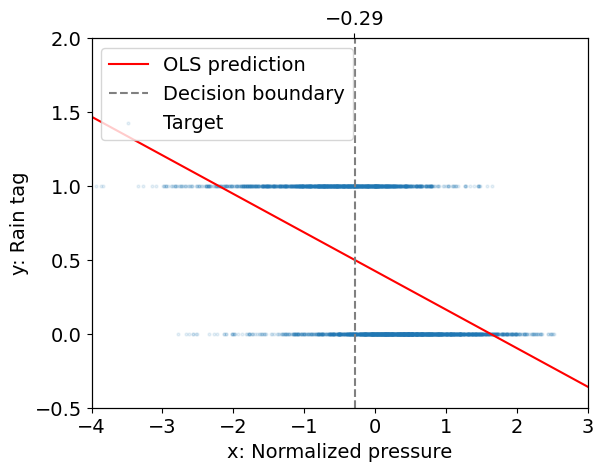

In [2]:
# Import the linear regression class
from sklearn.linear_model import LinearRegression

# Fit linear regression model
ols = LinearRegression()
_ = ols.fit(df_day[['sp']], df_day['tag'])

# Get decision boundary
boundary = (.5 - ols.intercept_) / ols.coef_[0]

# Plot targets and predictions
fig, ax = plt.subplots()
sp_test = np.linspace(-4, 3, 300)
ax.plot(sp_test, ols.coef_ * sp_test + ols.intercept_, 'r',
        label="OLS prediction")
ax.axvline(boundary, linestyle='--', color='.5',
           label="Decision boundary")
ax.scatter(df_day['sp'], df_day['tag'], s=4, alpha=0.1,
           label="Target")
ax.set_xlabel('x: Normalized pressure')
ax.set_ylabel('y: Rain tag')
ax.set_xlim(-4, 3.)
ax.set_ylim(-0.5, 2.)
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks([boundary.round(2)])
_ = ax.legend(loc='upper left')

**Interpretation:**
- The fit that we obtain is not too bad: there seem to be a tendency for low pressure days to be rainy and high pressure days to be dry, with a decision boundary given by $x \approx -0.29$.
- This is not fully satisfactory however because $y(x)$ is not restricted to take values between 0 and 1 and so $y$ is not a probability.

<div class="alert alert-block alert-warning">
    <b>Warning</b>
    
- For $K = 2$, linear regression of the indicator response(s) provides coefficients that correspond to those of linear discriminant analysis but for the intercept (Chap. 4 in Hastie *et al.* 2009).
- Linear regression for classification easily generalizes to multiple classes. However, for $K > 2$, classes can be masked by others due to the rigid nature of the linear regression model (Chap. 4 in Hastie *et al.* 2009).
    
</div>

## Logistic regression

### Logistic regression for two classes and one input

In order to address the above problem, we are going to fit a non-linear function of $x$ called the sigmoid:

\begin{equation}
y(x) = \frac{1}{1 + e^{-x}}
\end{equation}

> ***Question***
> - Check that for any $x$, $0 < y(x) < 1$.
> - For which value of $x$ do we have $y(x) = 0.5$.
> - Introduce a parameter in the function in order to control that threshold.
> - Introduce a second parameter to control the speed of the transition from $y\simeq 0$ to $y\simeq 1$.

- Hence, $y(x)$ can be interpreted as a probability conditioned on the observation $x$.
- In order to adjust this conditional probability, we introduce the parameters $\beta_0$ and $\beta_1$ and maximize the probability $y(\beta_0 + \beta_1 x)$, so that the decision boundary is at $x = -\beta_0 / \beta_1$.
- Because this function is non-linear, we no longer have an analytical solution and we instead need a non-linear solver to find $\beta_0$ and $\beta_1$.

Below is an example for the same data set as above using the `linear_model.LogisticRegression` model implemented in Scikit-Learn.

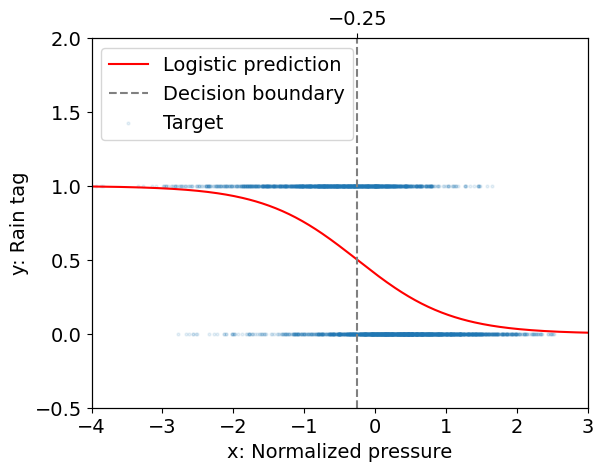

In [3]:
# Import the logistic regression class
from sklearn.linear_model import LogisticRegression

# Define sigmoid function
def sigmoid(x):                                        
    return 1 / (1 + np.exp(-x))

# Fit logistic regression model using scikit-learn
clf = LogisticRegression()
clf.fit(df_day[['sp']], df_day['tag'])

# Get decision boundary
boundary = -clf.intercept_[0] / clf.coef_[0, 0]

# Plot target and predictions
fig, ax = plt.subplots()
loss = sigmoid(sp_test * clf.coef_[0, :] + clf.intercept_)
ax.plot(sp_test, loss, color='red', label="Logistic prediction")
ax.axvline(boundary, linestyle='--', color='.5',
           label="Decision boundary")
ax.scatter(df_day['sp'], df_day['tag'], s=4, alpha=0.1,
           label="Target")
ax.set_xlabel('x: Normalized pressure')
ax.set_ylabel('y: Rain tag')
ax.set_xlim(-4, 3.)
ax.set_ylim(-0.5, 2.)
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks([boundary.round(2)])
_ = ax.legend(loc='upper left')

**Interpretation:**

- The decision boundary for logistic regression ($x \approx -0.25$) is close to that for linear regression ($x \approx -0.29$).
- However we can now assign an estimate of the probability for the "rain" event given an observation of the pressure.
- That probability depends on the distance of the observed pressure to the pressure at the decision boundary, i.e. on both $\beta_0$ and $\beta_1$, while its rate of change with the input is controled by $\beta_1$.

Note that the sigmoid function has many interesting properties. For instance we can invert this function to get

\begin{equation}
x = \ln\frac{y}{1 -y}
\end{equation}

where $x$ is now the logarithm of the odds. This function $x(y)$ is called the *logit* function.

Another property is that the derivative of the sigmoid is easy to compute:

\begin{equation}
\frac{dy}{dx} = y(1-y)
\end{equation}

We will use this property when we will study neural networks.

### Generalization to multiple classes and inputs

- The example above is relatively straightforward because there are only two classes.
- We took advantage of this when we identified the class identifier with the probability of one of the two classes given the input.
- We can no longer do that when we consider more than two classes.

In the multiple class problem the logistic function can be generalized to,

\begin{equation}
P(C = k | \boldsymbol X = \boldsymbol x) := y_k(\boldsymbol x) = \frac{\exp(\beta_{k 0} + \boldsymbol \beta_k^\top \boldsymbol x) }{\sum_{l = 1}^{K - 1} \exp (\beta_{l0} + \boldsymbol \beta_l^\top \boldsymbol x)},
\end{equation}

where $\beta_{k0}$ in $\mathbb{R}$ and $\boldsymbol \beta_k$ in $\mathbb{R}^p$ for $1 \le k \le K - 1$.

As before we can use a non linear solver to find the numerical values of the $\beta_{k0}$ and $\boldsymbol \beta_k$.

### Link to Linear Discriminant Analysis (LDA)

In the case of LDA ([Classification I: Generative models](06_classification_generative.ipynb)), the log-posterior odds between class $k$ and $K$ are linear functions of $\boldsymbol x$:

$$
\begin{aligned}
\log \frac{P(C = k | \boldsymbol X = \boldsymbol x)}{P(C = K | \boldsymbol X = \boldsymbol x)}
&= - \frac{1}{2} (\boldsymbol \mu_k + \boldsymbol \mu_K)^\top \boldsymbol \Sigma^{-1} (\boldsymbol \mu_k - \boldsymbol \mu_K) \\
&+\log \frac{P_k}{P_K}
+ (\boldsymbol \mu_k - \boldsymbol \mu_K)^\top \boldsymbol \Sigma^{-1} \boldsymbol x \\
&= \alpha_{k 0} + \boldsymbol \alpha_{k}^\top \boldsymbol x
\end{aligned}
$$

This linearity is a consequence of the Gaussian assumption for the class
densities, as well as the assumption of a common covariance matrix.

The linear logistic model by construction has linear logits:

$$
\begin{aligned}
\log \frac{P(C = k | \boldsymbol X = \boldsymbol x)}{P(C = K | \boldsymbol X = \boldsymbol x)}
&= \beta_{k 0} + \boldsymbol \beta_{k}^\top \boldsymbol x
\end{aligned}
$$

- It seems that the models are the same.
- However, LDA assumes that $P(\boldsymbol X = \boldsymbol x)$ is a Gaussian mixture, while we can think of it as being estimated in a fully nonparametric and unrestricted fashion in logistic regression.
- It is generally felt that logistic regression is a safer, more robust bet than the LDA model, relying on fewer assumptions, even though results may be similar in practice (Chap. 4 in Hastie *et al.* 2009).

### Conclusion on logistic regression

- Logistic regression is a powerful strategy that does not make any assumption about the distribution of the data in the input space.
- It provides a probability of belonging to a class given an input.
- The major drawback of the logistic regression is that, by design, we suppose that there is a linear relationship between the log odds of the output variable and the input variables.
- This is problematic of course when this relation does not hold in which case nonlinear models may be needed.

## Optimal dimension reduction for classification: Fisher Linear Discriminant Analysis

- So far, we have not considered problems with a high number of features.
- However, the feature space is often high-dimensional, thus prohibiting visualizing the classes and making overfitting more likely. 
- Fisher Linear Discriminant Analysis (F-LDA) is a method to tackle this problem: it relies on projecting the data set onto a reduced number of dimensions that are best suited to separate the classes.
- (Another other popular tool for dimension reduction is *Principal Component Analysis*, see [Introduction to Unsupervised Learning with a Focus on PCA](08_unsupervised_learning_pca.ipynb).)

To present this method, let us use a 2-dimensional dataset $(\boldsymbol x_i, k_i), 1 \le i \le N$ with two classes $C = 0$ and $C = 1$ (e.g. pressure and temperature and no rain/rain).

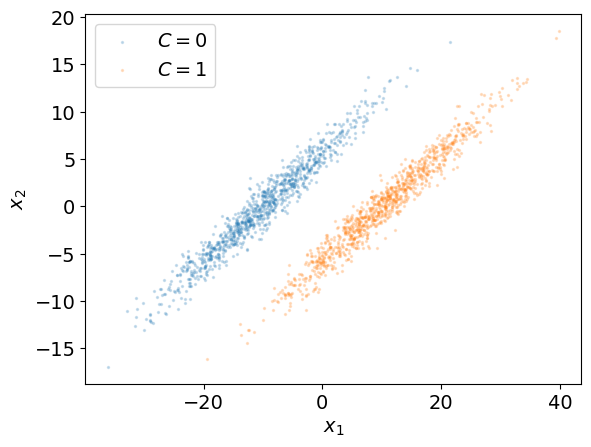

In [68]:
CLASS_LABELS = [r'$C = 0$', r'$C = 1$']
DIM_LABELS = [r'$x_1$', r'$x_2$']

N = 1000
THETA = np.pi / 6
MU_1 = np.array([-10, 0])
MU_2 = np.array([10, 0])
SIGMA_V = np.array([10, 1])

Rw = np.array([[np.cos(THETA), -np.sin(THETA)],
               [np.sin(THETA), np.cos(THETA)]])
Cv = np.diag(SIGMA_V**2)
Cw = Rw @ Cv @ Rw.T

z1 = np.random.multivariate_normal(MU_1, Cw, N)
z2 = np.random.multivariate_normal(MU_2, Cw, N)

fig, ax = plt.subplots(1)
s = 2
alpha_scatter = 0.2
ax.scatter(z1[:, 0], z1[:, 1], s=s, alpha=alpha_scatter,
           label=CLASS_LABELS[0])
ax.scatter(z2[:, 0], z2[:, 1], s=s, alpha=alpha_scatter,
           label=CLASS_LABELS[1])
ax.set_xlabel(DIM_LABELS[0])
ax.set_ylabel(DIM_LABELS[1])
_ = ax.legend()

In the example above, we have observations from two distinct and well separated classes: a boundary separating these classes can be drawn.

The plots below represent the histograms of the data along the dimensions $x_1$ and $x_2$ in order to study whether or not the classes can be separated in each of these dimensions.

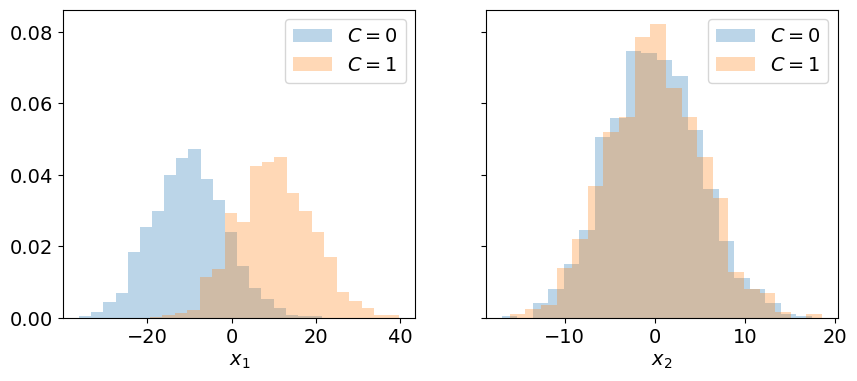

In [69]:
ztot = np.concatenate((z1, z2), 0)

alpha_hist = 0.3
density = True
bins = 20

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(10, 4))
ax[0].hist(z1[:, 0], bins, density=density, alpha=alpha_hist,
           label=CLASS_LABELS[0])
ax[0].hist(z2[:, 0], bins, density=density, alpha=alpha_hist,
           label=CLASS_LABELS[1])
ax[0].set_xlabel(DIM_LABELS[0])
ax[0].legend()

ax[1].hist(z1[:, 1], bins, density=density, alpha=alpha_hist,
           label=CLASS_LABELS[0])
ax[1].hist(z2[:, 1], bins, density=density, alpha=alpha_hist,
           label=CLASS_LABELS[1])
ax[1].set_xlabel(DIM_LABELS[1])
_ = ax[1].legend()

**Interpretation:**

The projection of the data from the original parameter space $(x_1, x_2)$ to each dimension mixes the two classes: they can no longer be separated by a boundary.

**Problem:**

Can we find a vector given by the linear combination of $\boldsymbol e_1$ and $\boldsymbol e_2$ so that the two classes are best separated for the data projected on this vector?

We look for a vector $\boldsymbol \beta$ that best *discriminate* between the two classes.

Given $\boldsymbol \beta$, the projection of an input vector on this vector is given by 

\begin{equation}
z = \boldsymbol \beta^\top \boldsymbol x.
\end{equation}

We can then propose a threshold $z_0$ such that if $z > z_0$ we assign a point to class $C = 0$ and if $ z \le z_0$ we assign this point to $C = 1$. 

> ***Question***
> - In the example above, do you have an idea of which axis you could use to project the data and get maximum class separability?

### A first attempt: maximizing the distance between the conditional means

In order to find a direction that best separates each class, a first approach could to maximize the distance between the sample means of the input data for each class.

In the original coordinate system, these means are given by,

\begin{equation}
\begin{aligned}
\hat{\boldsymbol \mu}_0 &= \frac{1}{N_0} \sum_{i, k_i = 0} \boldsymbol x_i\\
\hat{\boldsymbol \mu}_1 &= \frac{1}{N_1} \sum_{i, k_i = 1} \boldsymbol x_i.
\end{aligned}
\end{equation}

The projection of these means onto the vector $\boldsymbol \beta$ is given by,

\begin{equation}
\begin{aligned}
    \nu_0^{\boldsymbol \beta} &= \boldsymbol \beta^\top \hat{\boldsymbol \mu}_0\\
    \nu_1^{\boldsymbol \beta} &= \boldsymbol \beta^\top \hat{\boldsymbol \mu}_1 .
\end{aligned}
\end{equation}

**Objective:** Find the vector $\boldsymbol \beta$ that maximizes

\begin{equation}
J(\boldsymbol \beta) = \left(\nu_1^{\boldsymbol \beta} - \nu_0^{\boldsymbol \beta}\right)^2.
\end{equation}

> ***Question (optional)***
> - Show that 
\begin{equation}
\left(\nu_1^{\boldsymbol \beta} - \nu_0^{\boldsymbol \beta}\right)^2
= \boldsymbol \beta^\top \boldsymbol S_b \boldsymbol \beta,
\end{equation}
> with 
\begin{equation}
\boldsymbol S_b :=
\left(\hat{\boldsymbol\mu}_1^{\boldsymbol \beta} - \hat{\boldsymbol\mu}_0^{\boldsymbol \beta}\right)
\left(\hat{\boldsymbol\mu}_1^{\boldsymbol \beta} - \hat{\boldsymbol\mu}_0^{\boldsymbol \beta}\right)^\top,
\end{equation}
> the *between* class scatter matrix.

The cost function can be arbitrarily big if we take $\boldsymbol \beta$ as big as we want.

In order to find the direction $\boldsymbol \beta$, we need to add a constraint on the norm $\lVert \boldsymbol \beta \lVert$ to the cost function.

The new cost function is,

\begin{equation}
J(\boldsymbol \beta) = \left(\hat{\nu}_1^{\boldsymbol \beta} - \hat{\nu}_0^{\boldsymbol \beta}\right)^2
- \lambda (\boldsymbol \beta^\top \boldsymbol \beta - 1),
\end{equation}

with $\lambda \ge 0$ a Lagrange multiplier.

> ***Question (optional)***
> - Differentiate the cost function $J(\boldsymbol \beta)$ with respect to $\boldsymbol \beta$ and show that $\nabla J = 0$ when 
\begin{equation}
 \boldsymbol S_b \boldsymbol \beta = \lambda \boldsymbol \beta,
\end{equation}
> for some $\lambda \ge 0$.

However, 
\begin{equation}
\begin{aligned}
\boldsymbol S_b \boldsymbol \beta
&= \left(\hat{\boldsymbol\mu}_1^{\boldsymbol \beta} - \hat{\boldsymbol\mu}_0^{\boldsymbol \beta}\right)
\left[\left(\hat{\boldsymbol\mu}_1^{\boldsymbol \beta} - \hat{\boldsymbol\mu}_0^{\boldsymbol \beta}\right)^\top \boldsymbol \beta\right] \\
& \propto \left(\hat{\boldsymbol\mu}_1^{\boldsymbol \beta} - \hat{\boldsymbol\mu}_0^{\boldsymbol \beta}\right).
\end{aligned}
\end{equation}
In other words, $\boldsymbol S_b$ is a matrix that projects on $\hat{\boldsymbol\mu}_1^{\boldsymbol \beta} - \hat{\boldsymbol\mu}_0^{\boldsymbol \beta}$.

Thus, $J$ is maximum when 
\begin{equation}
\boldsymbol \beta \propto \left(\hat{\boldsymbol\mu}_1^{\boldsymbol \beta} - \hat{\boldsymbol\mu}_0^{\boldsymbol \beta}\right).
\end{equation}

That is $\boldsymbol \beta$ is the direction that joins the two sample means.

Unfortunately, this does not necessarily ensure that the classes are well separated when projected onto $\boldsymbol \beta$.

For instance, the line spanned by this vector is represented below for our example.

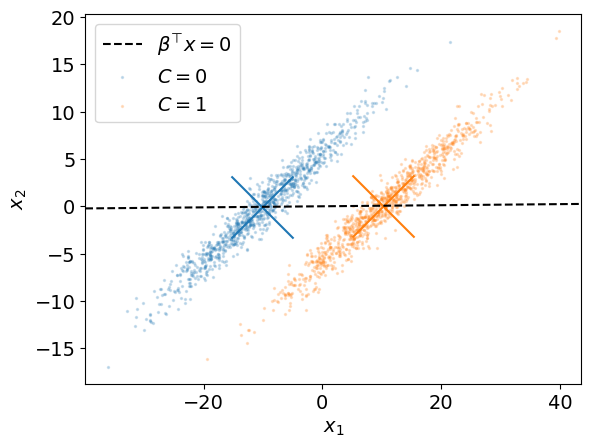

In [85]:
mu_0_hat = z1.mean(0)
mu_1_hat = z2.mean(0)
beta = (mu_1_hat - mu_0_hat)

fig, ax = plt.subplots(1)
s_mu = s * 1000
marker_mu = 'x'
ax.scatter(z1[:, 0], z1[:, 1], s=s, alpha=alpha_scatter,
           label=CLASS_LABELS[0])
ax.scatter(z2[:, 0], z2[:, 1], s=s, alpha=alpha_scatter,
           label=CLASS_LABELS[1])
ax.scatter(*mu_0_hat, s=s_mu, marker=marker_mu, c=RC_COLORS[0])
ax.scatter(*mu_1_hat, s=s_mu, marker=marker_mu, c=RC_COLORS[1])
xlim = ax.get_xlim()
ylim = ax.get_ylim()
x = np.linspace(*xlim, 1000)
y_line = mu_0_hat[1] + beta[1] / beta[0] * (x - mu_0_hat[0])
ax.plot(x, y_line, '--k', label=r'$\beta^\top x = 0$')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xlabel(DIM_LABELS[0])
ax.set_ylabel(DIM_LABELS[1])
_ = plt.legend()

### Second attempt: maximizing the means relatively to the variances

We introduce for each class a quantity that is proportional to the sample variance of the data projected on $\beta$:

\begin{equation}
\begin{aligned}
\left(s_0^{\boldsymbol \beta}\right)^2
&= \sum_{i, k_i = 0} \left(\boldsymbol \beta^\top \boldsymbol x_i - \nu_0^{\boldsymbol \beta}\right)^2\\
\left(s_1^{\boldsymbol \beta}\right)^2
&= \sum_{i, k_i = 1} \left(\boldsymbol \beta^\top \boldsymbol x_i - \nu_1^{\boldsymbol \beta}\right)^2,
\end{aligned}
\end{equation}

Then, we want $(s_0^{\boldsymbol \beta})^2 + (s_1^{\boldsymbol \beta})^2$ to be as small as possible. 

In a similar way as before, we can show that

\begin{equation}
\left(s_0^{\boldsymbol \beta}\right)^2 + \left(s_1^{\boldsymbol \beta}\right)^2
= \boldsymbol \beta^\top \boldsymbol S_w \boldsymbol \beta
\end{equation}

with $\boldsymbol S_w$ the *within* class scatter matrix,

\begin{equation}
\boldsymbol S_w
:= \sum_{i, k_i = 0} (\boldsymbol x_i - \hat{\boldsymbol\mu}_0^{\boldsymbol \beta})
(\boldsymbol x_i - \hat{\boldsymbol\mu}_0^{\boldsymbol \beta})^\top
+ \sum_{i, k_i = 1} (\boldsymbol x_i - \hat{\boldsymbol\mu}_1^{\boldsymbol \beta})
(\boldsymbol x_i - \hat{\boldsymbol\mu}_1^{\boldsymbol \beta})^\top.
\end{equation}

We define a new cost function that combines these two metrics:

\begin{equation}
J(\mathbf w) = \frac{\left(\hat{\nu}_1^{\boldsymbol \beta} - \hat{\nu}_0^{\boldsymbol \beta}\right)^2}{\left(s_0^{\boldsymbol \beta}\right)^2 + \left(s_1^{\boldsymbol \beta}\right)^2}
\end{equation}

The maximum of this cost function corresponds to the maximum separation of the sample means relative to the sample variances. 

We can write the cost function explicitly with the vector $\boldsymbol \beta$:

\begin{equation}
J(\boldsymbol \beta) = \frac{\boldsymbol \beta^\top \boldsymbol S_b \boldsymbol \beta}{\boldsymbol \beta^\top \boldsymbol S_w \boldsymbol \beta}
\end{equation}

Once again, to find the maximum of this cost function we can differenciate it with respect to $\boldsymbol \beta$.

> ***Question (optional)***
> - Show that for $\boldsymbol \beta$ to maximize $J$, it must be such that,
\begin{equation}
\left(\boldsymbol \beta^\top \boldsymbol S_b \boldsymbol \beta\right) \boldsymbol S_w \boldsymbol \beta
= \left(\boldsymbol \beta^\top \boldsymbol S_w \boldsymbol \beta\right) \boldsymbol S_b \boldsymbol \beta.
\end{equation}

Both quantities in parenthesis are scalars.
They affect the norm of $\boldsymbol \beta$ but not its direction (what we are actually looking for).

We can then formulate this problem as a generalized eigenvalue problem:

\begin{equation}
\boldsymbol S_w \boldsymbol \beta = \lambda \boldsymbol S_b \boldsymbol \beta.
\end{equation}

For the two-classes case considered here, we saw above that $\boldsymbol S_b$ is the projection matrix on $\hat{\boldsymbol\mu}_1^{\boldsymbol \beta} - \hat{\boldsymbol\mu}_0^{\boldsymbol \beta}$.

Thus, we have

\begin{equation}
\boldsymbol \beta \propto \boldsymbol S_w^{-1} (\hat{\boldsymbol\mu}_1^{\boldsymbol \beta} - \hat{\boldsymbol\mu}_0^{\boldsymbol \beta}).
\end{equation}

Note that this equation requires that $\boldsymbol S_w$ be invertible.

This condition is satisfied when the features are not colinear.

Below, we use `np.linalg.solve` to solve the above generalized eigenvalue problem for our example.

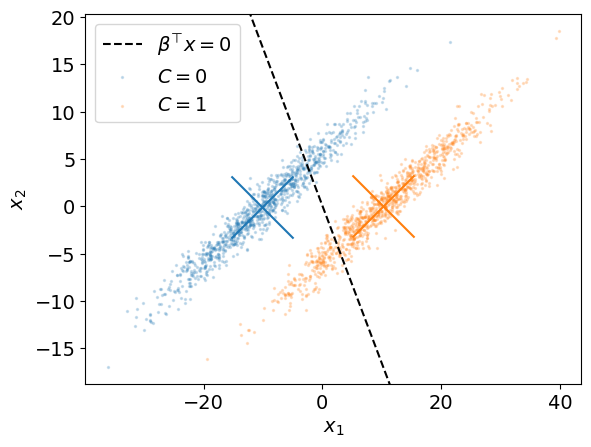

In [87]:
beta = np.linalg.solve(Cw, mu_1_hat - mu_0_hat) # we use C_w instead of S_w

fig, ax = plt.subplots(1)
mu_avg_hat = (mu_0_hat + mu_1_hat) / 2
ax.scatter(z1[:, 0], z1[:, 1], s=s, alpha=alpha_scatter,
           label=CLASS_LABELS[0])
ax.scatter(z2[:, 0], z2[:, 1], s=s, alpha=alpha_scatter,
           label=CLASS_LABELS[1])
ax.scatter(*mu_0_hat, s=s_mu, marker=marker_mu, c=RC_COLORS[0])
ax.scatter(*mu_1_hat, s=s_mu, marker=marker_mu, c=RC_COLORS[1])
xlim = ax.get_xlim()
ylim = ax.get_ylim()
y_line = mu_avg_hat[1] + beta[1] / beta[0] * (x - mu_avg_hat[0])
ax.plot(x, y_line, '--k', label=r'$\beta^\top x = 0$')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xlabel(DIM_LABELS[0])
ax.set_ylabel(DIM_LABELS[1])
_ = plt.legend()

Once we have determined $\boldsymbol \beta$, we can project the dataset onto it.

Doing so, the feature space is reduced to a single dimension.

This is illustrated below for our example.

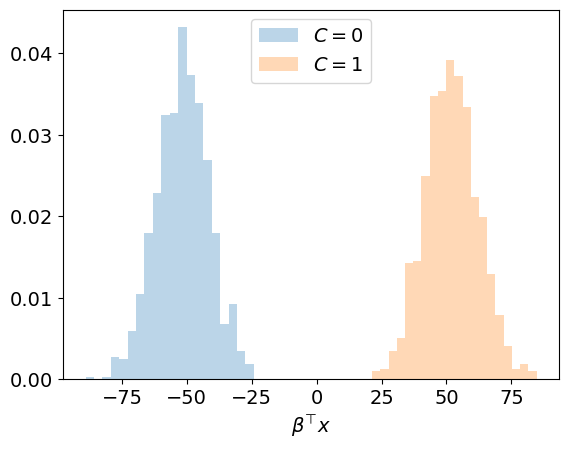

In [91]:
# Project inputs on beta
z1_proj = z1 @ beta
z2_proj = z2 @ beta

fig, ax = plt.subplots(1)
ax.hist(z1_proj, bins, density=density, alpha=alpha_hist,
        label=CLASS_LABELS[0])
ax.hist(z2_proj, bins, density=density, alpha=alpha_hist,
        label=CLASS_LABELS[1])
ax.set_xlabel(r'$\beta^\top x$')
_ = ax.legend()

**Interpretation:**

- The inputs associated with the two classes are clearly separated in the one-dimensional space defined by $\boldsymbol \beta$.

**Remark:**
- Fisher's linear discriminant, although strictly it is not a discriminant but rather a speciﬁc choice of direction for projection of the data down to one dimension.
- However, the projected data can subsequently be used to construct a discriminant, by choosing a threshold for $\boldsymbol \beta^\top \boldsymbol x$, for instance using standard linear discriminant analysis [Classification I: Generative models](06_classification_generative.ipynb).

## To go further

- Fisher's linear discriminant can be generalized to any number $K$ of classes and for $p$ dimensions provided that $K \le p$ and that $q \le K - 1$, with $q$ the dimension of the reduced space. (Chap. 4 in Bishop 2006).

## References

- [Bishop, C., 2006. Pattern Recognition and Machine Learning, Information Science and Statistics. Springer-Verlag, New York](//www.springer.com/us/book/9780387310732).
- [Hastie, T., Tibshirani, R., Friedman, J., 2009. The Elements of Statistical Learning, 2nd ed. Springer, New York](https://doi.org/10.1007/978-0-387-84858-7).

***
## Credit

[//]: # "This notebook is part of [E4C Interdisciplinary Center - Education](https://gitlab.in2p3.fr/energy4climate/public/education)."
Contributors include Bruno Deremble and Alexis Tantet.

<br>

<div style="display: flex; height: 70px">
    
<img alt="Logo LMD" src="images/logos/logo_lmd.jpg" style="display: inline-block"/>

<img alt="Logo IPSL" src="images/logos/logo_ipsl.png" style="display: inline-block"/>

<img alt="Logo E4C" src="images/logos/logo_e4c_final.png" style="display: inline-block"/>

<img alt="Logo EP" src="images/logos/logo_ep.png" style="display: inline-block"/>

<img alt="Logo SU" src="images/logos/logo_su.png" style="display: inline-block"/>

<img alt="Logo ENS" src="images/logos/logo_ens.jpg" style="display: inline-block"/>

<img alt="Logo CNRS" src="images/logos/logo_cnrs.png" style="display: inline-block"/>
    
</div>

<hr>

<div style="display: flex">
    <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0; margin-right: 10px" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a>
    <br>This work is licensed under a &nbsp; <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.
</div>